In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# get europe country name to iso mapping
mapping = pd.read_excel('/home/gidden/work/iiasa/datasources/region_mappings/MESSAGE_regional_coding_20160625.xlsx', index_col=1)
eur = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'United Kingdom']
eur = [mapping.ISO3.loc[c] for c in eur]

# Get Projection Data

In [3]:
# import and clean up
df = pd.read_csv('adjusted_multi_single.csv') # result of smooth.ipynb
df.columns = ['scenario'] + list(df.columns[1:])
df.columns.name = 'iso'

In [4]:
# grab watned columns
df = df[df.scenario.str.startswith(('mSSP', 'std'))]
df.scenario = df.scenario.apply(lambda x: x[1:])
df = df.set_index(['scenario', 'year']).stack().reset_index()#.unstack('year').reset_index()

In [5]:
# reduce
df.iso = df.iso.apply(lambda x: 'EUR' if x in eur else x)
df = df[(df.scenario.isin(['SSP1', 'SSP4', 'td'])) & (df.iso.isin(['EUR', 'USA', 'IND', 'CHN']))]
df = df.groupby(['scenario', 'year', 'iso']).median()

In [6]:
# clean up std, super hacky, could be cleaned up
std = df.loc['td']
df['std'] = np.nan
df.loc['SSP1']['std'] = std
df.loc['SSP4']['std'] = std
df.columns = ['gini', 'std']
df = df.drop('td')
projginis = df

In [7]:
# bring in income
inc = pd.read_csv('SSP_GDP.csv')
inc.columns = ['year', 'scenario', 'iso', 'inc']
inc.iso = inc.iso.str.replace('EU15', 'EUR')
inc = inc.set_index(['scenario', 'year', 'iso']).sort_index()

In [8]:
# add income, only use years where projections exist
projginis['inc'] = inc
proj = projginis.dropna()
proj.head()

gini        std    inc
scenario year iso                             
SSP1     2020 CHN  44.944191  14.254101  15231
              EUR  29.309810  11.545145  34250
              IND  35.485001   8.708382   5079
              USA  41.544552  11.985305  50642
         2030 CHN  42.030357  19.975763  28413

# Get Historical Data

In [9]:
hist = pd.read_csv('Hist_GDP_Gini_Data.csv')
hist.columns = ['iso', 'year', 'gini', 'inc']
hist = hist[hist.year >= 2000]
hist.iso = hist.iso.apply(lambda x: 'EUR' if x in eur else x)
hist = hist[hist.iso.isin(['EUR', 'USA', 'IND', 'CHN'])]
hist = hist.groupby(['iso', 'year']).median()
hist = hist.interpolate()
hist = hist.reset_index()
hist = hist[hist.year <= 2010]
hist['std'] = 0
hist.head()

,iso,year,gini,inc,std
0,CHN,2000,39.000000,2667.469383,0
1,CHN,2001,40.966667,2867.961183,0
2,CHN,2002,42.933335,3108.051800,0
3,CHN,2003,44.900002,3397.628437,0
4,CHN,2004,45.357144,3718.636985,0


# Plot

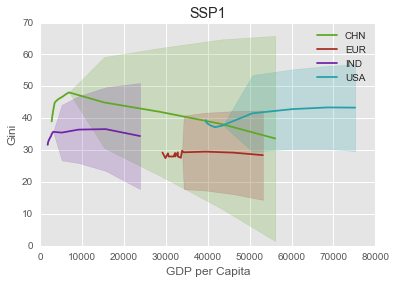

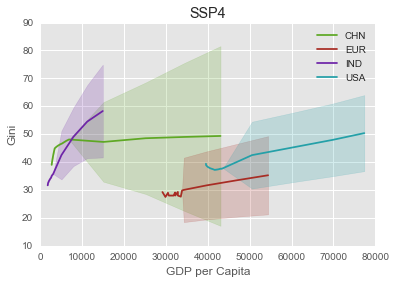

In [10]:
palette = sns.color_palette(sns.hls_palette(n_colors=4, l=.4))
colors = {i: palette.pop() for i in set(hist.iso)}

alldata = proj.reset_index().set_index('scenario')

for ssp in ['SSP1', 'SSP4']:
    df = pd.concat([alldata.loc[ssp], hist])
    df = df.set_index('iso')
    for iso in sorted(set(df.index)):
        data = df.loc[iso].sort_values(by='inc')
        plt.plot(data.inc, data.gini, label=iso.upper(), c=colors[iso])
        plt.fill_between(data.inc, data.gini - data['std'], data.gini + data['std'], alpha=.2, color=colors[iso])
    plt.legend(loc='best')
    plt.xlabel('GDP per Capita')
    plt.title(ssp)
    plt.ylabel('Gini')
    plt.show()
    plt.clf()